# Optimization of Galactic Science Survey Region

TVS have combined a number of science use-cases to derive a region within the Galactic Plane and Magellanic Clouds of high priority for a survey with the Rubin Observatory.  

This priority map combines a priority based on galactic stellar density distribution as a function of position, with specific regions of special scientific interest, such as Star Forming Regions.  

As a result, the map is quite pixelated, comprising of a large number of small, discontiguous regions, which is inefficient when observations are implemented in the LSST scheduler, due to the dithering function applied to each visit.  

Therefore, it is beneficial to explore optimizations to this priority map which lead to a smaller number of larger, contiguous regions.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline
import rubin_sim.maf as maf
from rubin_sim.data import get_data_dir
import healpy as hp
from astropy import units as u
from astropy_healpix import HEALPix
from astropy.coordinates import Galactic, TETE, SkyCoord
from astropy.io import fits
from sklearn.cluster import DBSCAN, MiniBatchKMeans, OPTICS, MeanShift

NSIDE = 64
NPIX = hp.nside2npix(NSIDE)

# Total number of visits to the combined galactic science region of interest:
NTotalVisits = 2088400

# Time taken per visit [in seconds] to a single field (estimated, taken from https://lsst.org/scientists/keynumbers):
TimePerVisit = 42.2

# Area surveyed in a single visit [sq deg]:
AreaPerVisit = 9.6

## Galactic science priority region maps

This analysis is derived from the priority maps produced previously, so we load those here:

Number of HEALpixels in desired survey region with priority > 0.21: 2898


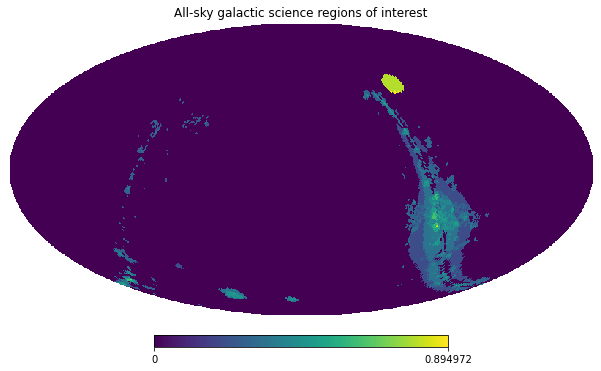

In [2]:
# Load the galactic science priority map data from the "sum" file
home = os.path.expanduser("~")
#galSciencePriorityMapFile = os.path.join(home, 'rubin_sim_data/maps/GalacticPlanePriorityMaps/priority_GalPlane_footprint_map_data_sum.fits')
galSciencePriorityMapFile = os.path.join(home, 'software/LSST-TVS_software_tools/footprint_maps/priority_GalPlane_footprint_map_data_sum.fits')

with fits.open(galSciencePriorityMapFile) as hdul:
    galSciencePriorityMapTable = hdul[1].data

# The sum priority map sums the priority assigned to all HEALpixels over all 6 LSST filters.  
# For ease of understanding, it is valid to average this over all filters here.  
# We also select the combined region map, as opposed to the maps for the distinct science cases
priorityMap = getattr(galSciencePriorityMapTable, 'combined_map')
priorityMap /= 6

# Select submap data, if desired:
priorityThreshold = 0.21
priorityMapPixels = np.where(priorityMap > priorityThreshold)[0]
print('Number of HEALpixels in desired survey region with priority > '+str(priorityThreshold)+': '+str(len(priorityMapPixels)))
selectedMap = np.zeros(len(priorityMap))
selectedMap[priorityMapPixels] = priorityMap[priorityMapPixels]

# For illustration, plot the full map data:
hp.mollview(selectedMap, title='All-sky galactic science regions of interest')



These maps were designed to be all-sky, so we first factor in the Rubin visibility zone

/Users/rstreet1/software/LSST-TVS_software_tools/footprint_maps/baseline_v2.0_10yrs_rubin_visibility_zone.fits
False


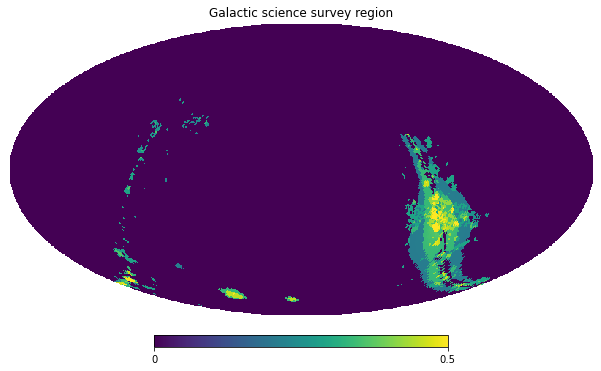

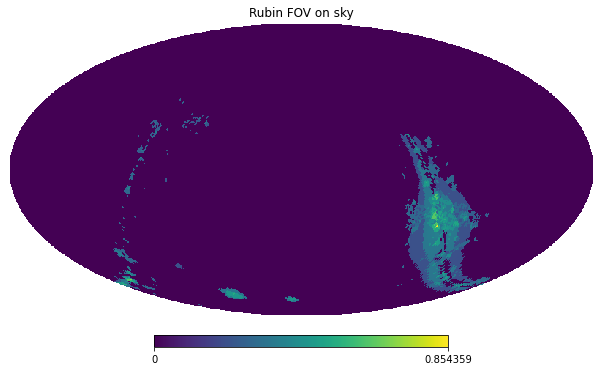

In [10]:
home = os.path.expanduser("~")
visibilityMapFile = os.path.join(home, 'software','LSST-TVS_software_tools','footprint_maps','baseline_v2.0_10yrs_rubin_visibility_zone.fits')
print(visibilityMapFile)

with fits.open(visibilityMapFile) as hdul:
    visibilityMap = hdul[1].data['visibility_map']

visiblePixels = np.where(visibilityMap > 0.0)[0]

mapPixels = list(set(priorityMapPixels).intersection(set(visiblePixels)))

surveyRegion = np.zeros(NPIX)
surveyRegion[mapPixels] = galSciencePriorityMapTable['combined_map'][mapPixels]

hp.mollview(surveyRegion, title='Galactic science survey region', min=0.0, max=0.5)

# Output this image in FITS image format:
projectedMap = hp.mollview(surveyRegion, title='Rubin FOV on sky', return_projected_map=True)
hdu = fits.PrimaryHDU(projectedMap.data)
fileName = os.path.join(home, 'software/LSST-TVS_software_tools/footprint_maps/priority_GalPlane_footprint_map_hp_image.fits')
hdu.writeto(fileName, overwrite=True)


## Optimizing the footprint by clustering algorithms

On the face of it, this problem looks well suited to a clustering algorithm or unsupervised machine learning approach, and there are many potential algorithms available (see for example https://machinelearningmastery.com/clustering-algorithms-with-python/).

Here I explore a few algorithms, focusing particularly on those that offer outlyer identification, as it is likely in this dataset that this will be necessary in order to isolate cluster regions. 

The first task with any algorithm is to build the feature dataset.  For our purposes, each sample represents a given HEALpixel and the features of interest are its separation from all other HEALpixels with non-zero priority, together with the priority of each HEALpixel.  

In [ ]:
# Create holding array for the dataset for the cluster analysis
dataset = np.zeros( (len(mapPixels),len(mapPixels)) )

# Calculating the coordinates of the center of each HEALpixel
(theta, phi) = hp.pix2ang(NSIDE, mapPixels)
pixel_ra = np.rad2deg(phi)
pixel_dec = np.rad2deg( (np.pi/2.0) - theta )
pixel_coords = SkyCoord(pixel_ra, pixel_dec,unit=(u.deg, u.deg),frame='icrs')

# Calculate the separations of each pixel from all other pixels. Tried to use meshgrid for this purpose but this 
# does not provide easy access to SkyCoords methods
for j in range(0,len(mapPixels),1):
    dataset[j,0:len(mapPixels)] = pixel_coords[j].separation(pixel_coords).data

# Append the pixel's priority as the last column in the dataset?
# Removed for now as this requires a mix of units in the feature arrays and hence more normalization
#dataset[:,len(mapPixels)] = surveyRegion[mapPixels]

### DBSCAN 

The first clustering algorithm I'm going to try is DBSCAN.  This was chosen because it is designed for non-flat geometry, uneven cluster sizes, outlier removal, and is transductive.  The metric used for optimization is the  distances between nearest points. 

The adjustable parameters for this algorithm are:
* eps = maximum distance between two samples for one to be considered as in the neighborhood of the other.  
    For most of our features, this is the on-sky angular separation in degrees, and the clusters we are looking for should be tens of degrees on a side.  However, the last column in dataset is the priority, which has different units.  For the time being we exclude this column from the dataset used.
* min_samples = number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself.

Note: This is very similar to the OPTICS algorithm, in which eps can be a range

In [ ]:
# Attempt to use DBSCAN algorithm
dataset1 = np.copy(dataset)
model1 = DBSCAN(eps=40, min_samples=5)
labels1 = model1.fit_predict(dataset1)
clusters1 = np.unique(labels1)
print('Identified '+str(len(clusters1))+' clusters')

In [ ]:
def plot_clusters_on_sky(mapPixels, dataset, model, clusters, labels, title='Clusters'):
    
    # Numerically offset the labels used to distinguish the labeled data from the 
    # plot background
    plot_labels = labels + 20
    region = np.zeros(NPIX)
    region[mapPixels] = plot_labels

    hp.mollview(region, title=title, cmap=plt.cm.tab10)

In [ ]:
plot_clusters_on_sky(mapPixels, dataset1, model1, clusters1, labels1, title='DBSCAN')

I spent some time optimizing the hyperparameters for the DBSCAN algorithm and found the "best" combination to be eps=40.0, min_samples=5.  

### OPTICS

A generalization of the DBSCAN algorithm, OPTICS offers the posibility of handling eps as a range.

In [ ]:
 # Attempt to use OPTICS algorithm
dataset1b = np.copy(dataset)
model1b = OPTICS(min_samples=20, xi=0.05, min_cluster_size=5)
labels1b = model1b.fit_predict(dataset1b)
clusters1b = np.unique(labels1b)
print('Identified '+str(len(clusters1b))+' clusters')
plot_clusters_on_sky(mapPixels, dataset1b, model1b, clusters1b, labels1b, title='OPTICS')

Significantly slower than DBSCAN, the results are not as convincing.

### Mini-Batch K-Means

Next algorithm to try is the Mini-Batch K-Means, which is recommended as an alternative to the BIRCH algorithm for datasets with more than 20 features, as here.  

The free parameter for this algorithm is the initial number of clusters to form, though the result seems insensitive to optimization.  

In [ ]:
dataset2 = np.copy(dataset)

model2 = MiniBatchKMeans(n_clusters=8)
model2.fit(dataset2)
labels2 = model2.fit_predict(dataset2)
clusters2 = np.unique(labels2)
print('Identified '+str(len(clusters2))+' clusters')


In [ ]:
plot_clusters_on_sky(mapPixels, dataset2, model2, clusters2, labels2, title='Mini-Batch K-means')

### Mean shift algorithm

This algorithm is designed for datasets with many clusters, uneven cluster size, non-flat geometry, inductive, though it does not handle outliers. 

In [ ]:
dataset6 = np.copy(dataset)
model6 = MeanShift()
labels6 = model6.fit_predict(dataset6)
clusters6 = np.unique(labels6)
print('Identified '+str(len(clusters6))+' clusters')
plot_clusters_on_sky(mapPixels, dataset6, model6, clusters6, labels6, title='Mini-Batch K-means')

This algorithm is slow and hard to optimize, since it has no hyperparameters.  

### RA, Dec-based dataset

An alternative approach is to give the algorithms the raw RA, Dec positions rather than the separations.

In [ ]:
# Create holding array for the dataset for the cluster analysis
dataset_positions = np.zeros( (len(mapPixels),2) )

# Calculating the coordinates of the center of each HEALpixel
(theta, phi) = hp.pix2ang(NSIDE, mapPixels)
dataset_positions[:,0] = np.rad2deg(phi)
dataset_positions[:,1] = np.rad2deg( (np.pi/2.0) - theta )

In [ ]:
# DBSCAN with RA, Dec coordinates
dataset3 = np.copy(dataset_positions)
model3 = DBSCAN(eps=20.0, min_samples=50)
labels3 = model3.fit_predict(dataset3)
clusters3 = np.unique(labels3)
print('Identified '+str(len(clusters3))+' clusters')
plot_clusters_on_sky(mapPixels, dataset3, model3, clusters3, labels3, title='DBSCAN')

Hyperparameter optimization suggests that this is ineffective.

In [ ]:
dataset4 = np.copy(dataset_positions)
model4 = MiniBatchKMeans(n_clusters=25)
model4.fit(dataset4)
labels4 = model4.fit_predict(dataset4)
clusters4 = np.unique(labels4)
print('Identified '+str(len(clusters4))+' clusters')
plot_clusters_on_sky(mapPixels, dataset4, model4, clusters4, labels4, title='Mini-Batch K-means')

So in general the clustering seems less effective using RA-Dec as features.  What about clustering by priority?

In [ ]:
dataset5 = np.zeros((len(mapPixels),2))
dataset5[:,0] = mapPixels
dataset5[:,1] = surveyRegion[mapPixels]
model5 = DBSCAN(eps=0.01, min_samples=2)
labels5 = model5.fit_predict(dataset5)
clusters5 = np.unique(labels5)
print('Identified '+str(len(clusters5))+' clusters')
plot_clusters_on_sky(mapPixels, dataset5, model5, clusters5, labels5, title='DBSCAN')

...no.  

## Next steps

Of all the algorithms tried, DBSCAN seemed to perform the best, but none of the options really achieved the localization I am looking for.  

Next option to consider is to take the priority map and "pixelize" it to the resolution of the Rubin FOV or a multiple of the FOV, designed to represent the dither function.  This may overcome the issue of the gaps in the central plane breaking up clusters.  

Then try contouring by pixel priority to identify contiguous regions. 

Reweighting of the relative priorities of the different science cases may be necessary.

Current pencilbeams are optimized by stellar density, which should in theory capture stellar clusters but not necessarily SFRs.  

Can the phot_utils.find_peaks function help to identify cluster centroids?
Maybe an iterative approach, where pixels are masked around peaks to an increasing radius as long as the mask-included priority increases "significantly"

-> Detect peaks with a largish footprint parameter designed to mimic a mosaic of Rubin pointings of minimum size. 
-> Figure out if there are neighbouring peaks within +/-1 footprint width that could be merged.  
-> Create a mask of the known peaks, including mergers. 
-> Iterate with the masked image to pick up increasingly low-level peaks, down to some priority threshold. 


## Exploring Rubin FOV relative to gaps in desired region

The Rubin sheduler is designed to dither around each survey pointing, making it inefficient to look at very small regions on the sky - effectively the observations are spread out around a given point rather than centered on it. 

This may be an issue for the Galactic Plane regions where dust extinction causes gaps in the desired HEALpixel region.  Should data on either side of the gap be treated as distinct regions, or is the Rubin dithered FOV large enough to simply span it?

In [ ]:
def calcPixelsWithinRadius(coord,radius):
    phi = np.deg2rad(coord.ra.deg)
    theta = (np.pi/2.0) - np.deg2rad(coord.dec.deg)
    radius = np.deg2rad(radius)
    xyz = hp.ang2vec(theta, phi)

    pixels = hp.query_disc(NSIDE, xyz, radius)
    return pixels

In [ ]:
map = np.zeros(NPIX)

# Test coordinates of central field pointing
l_center = -10.0
b_center = 0.0
radius = 3.5/2.0

# Work out which HEALpixels this covers
coord = SkyCoord(l_center*u.deg,b_center*u.deg,frame=Galactic())
coord = coord.transform_to('icrs')

pixels = calcPixelsWithinRadius(coord,radius)
print('HEALpixels in single Rubin pointing: ',len(pixels))

# Mark the Rubin FOV on the map
map[pixels] += 1.0

# Simulate a dither pattern by growing the FOV radius by a factor
ditherFactor = 2.0
radius *= ditherFactor
pixels = calcPixelsWithinRadius(coord,radius)
print('HEALpixels in '+str(ditherFactor)+'-dithered Rubin pointing: ',len(pixels))
map[pixels] += 1.0

# Overlay on the priority map:
priorityMap = getattr(galSciencePriorityMapTable, 'combined_map')
overlayMap = priorityMap 
overlayMap[pixels] = map[pixels]

projectedMap = hp.mollview(overlayMap, title='Rubin FOV on sky', return_projected_map=True)
print(projectedMap.shape)

So a Rubin pointing, especially with dithering, spans most of the gaps in the heavily extincted regions of the central Plane.  This suggests that the scheduler efficiency gained by using a contiguous region is more important than avoiding the gaps. 

## Exploring a peak-finding approach

To make it easier to apply standard astronomical software for identifying peaks in an image, the sky-projected data can be reprojected as a rectangular image using RA, Dec as the axes. 

In [ ]:
hdu = fits.PrimaryHDU(projectedMap)
fileName = os.path.join(home, 'software/LSST-TVS_software_tools/footprint_maps/priority_GalPlane_footprint_map_hp_image.fits')
hdu.writeto(fileName, overwrite=True)


Now let's try an object detection routine - couldn't conda install photutils so this will have to be via an external code/venv